In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -qq annotations_trainval2017.zip
!unzip -qq train2017.zip
!rm train2017.zip annotations_trainval2017.zip

In [ ]:
!pip install transformers pytorch_lightning tqdm pycocotools

# ViT to GPT2 Encoder Decoder Model

Using val dataset for demo, use train for actual production

https://www.kaggle.com/code/sachin/vit-to-gpt2-encoder-decoder-model/notebook

https://sachinruk.github.io/blog/pytorch/huggingface/2021/12/28/vit-to-gpt2-encoder-decoder-model.html

https://www.analyticsvidhya.com/blog/2021/01/implementation-of-attention-mechanism-for-caption-generation-on-transformers-using-tensorflow/



In [ ]:
import multiprocessing as mp
import random
from typing import Callable, Dict, List, Optional, Tuple, Union
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import io, transforms
import torchvision.datasets as dset
from tqdm.auto import tqdm
from transformers import EncoderDecoderModel, GPT2Tokenizer, ViTFeatureExtractor
# from transformers import GPT2TokenizerFast, ViTFeatureExtractor, VisionEncoderDecoderModel

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
MAX_TEXT_LENGTH = 32
NUM_WORKERS = mp.cpu_count()

loading annotations into memory...
Done (t=1.28s)
creating index...
index created!
Number of samples:  118287
Image Size torch.Size([3, 224, 224])
Sample Caption:  A wide walkway allows for walks along the river.


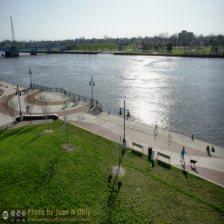

In [ ]:
# normalize so model easier to lear
# image = (image - mean) / std
# (mean=0.5, std=0.5) --> range [-1,1]
# minimum value 0 will be converted to (0 - 0.5) / 0.5 = -1
# maximum value of 1 will be converted to (1-0.5)/0.5=1
tfms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
   ]
)

# get image back in [0, 1]
# image = ((image * std) + mean)
descale = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=1 / 0.5),
        transforms.Normalize(mean=-0.5, std=[1., 1., 1.]),                           
    ]
)

# loading cocodataset
coco_dataset = dset.CocoCaptions(
    root = "train2017/",
    annFile = "annotations/captions_train2017.json",
    transform=tfms,
    target_transform=lambda x: random.choice(x),
)

print('Number of samples: ', len(coco_dataset))
img, caption = coco_dataset[20]
print('Image Size', img.size())
print('Sample Caption: ', caption)
transforms.ToPILImage()(descale(img))

In [ ]:
### test train split
train_len = int(.9 * len(coco_dataset))
train_data, valid_data = random_split(coco_dataset, [train_len, len(coco_dataset) - train_len])

train_dl = DataLoader(
    train_data, 
    BATCH_SIZE, 
    pin_memory=True, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    drop_last=True
)
valid_dl = DataLoader(
    valid_data, 
    BATCH_SIZE, 
    pin_memory=True, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    drop_last=False
)

images, captions = next(iter(train_dl))
images.shape, images.min(), images.max(), images.mean(), images.std()

(torch.Size([8, 3, 224, 224]),
 tensor(-1.),
 tensor(1.),
 tensor(-0.0334),
 tensor(0.5586))

In [ ]:
# appends EOS in begin and end (only neded for gpt2)
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

# set pad_token_id to unk_token_id -> be careful here as unk_token_id == eos_token_id == bos_token_id
gpt2_tokenizer.pad_token = gpt2_tokenizer.unk_token

gpt2_tokenizer_fn = lambda x: gpt2_tokenizer(
    x,
    max_length=MAX_TEXT_LENGTH,
    truncation=True,
    padding=True,
    return_tensors="pt",
)

# can try swin + bart
vit2gpt2 = EncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", 
    "gpt2"
)

In [ ]:
### nuclues sampling, minimises common pitfalls such as repetition when generating text

def top_k_top_p_filtering(
    next_token_logits: torch.FloatTensor,
    top_k: Optional[float]=None, 
    top_p: Optional[float]=None,
    device: Union[str, torch.device]="cuda") -> torch.FloatTensor:

    # softmax all 50k word tokens so all sum into 1 for each row
    # get the top K token for each row + use top P to cut off token
    # normalized the selected token and put it back
    # put the rest as 0

    if top_k is None:
        top_k = next_token_logits.shape[-1]
    if top_p is None:
        top_p = 1.0
    
    # [batch_size, num_token] -> [batch_size, top_k], index * proba
    # cummulative proba of all token is 1 after softmax
    p, largest_p_idx = F.softmax(next_token_logits, dim=-1).topk(top_k, dim=-1)

    # [batch_size, top_k], keep adding the values from 0 to topK
    cumulative_p = p.cumsum(dim=-1)

    # [top_p] x batch_size, [batch_size, 1]
    threshold_repeated = top_p + torch.zeros((len(p), 1)).to(device)

    # [batch_size], indexes
    idx = torch.searchsorted(cumulative_p, threshold_repeated).clip(max=top_k-1).squeeze()
    # [batch_size], probability
    cutoffs = cumulative_p[torch.arange(len(cumulative_p)), idx]

    # [batch_size, top_k]
    censored_p = (cumulative_p <= cutoffs[:, None]) * p    
    renormalized_p = censored_p / censored_p.sum(dim=-1, keepdims=True)
    
    # [batch_size, num_token]
    final_p = torch.zeros_like(next_token_logits)
    
    # [batch_size, top_k], [[0, 0, 0], [1, 1, 1], [2, 2, 2]]
    row_idx = torch.arange(len(p)).unsqueeze(1).repeat(1, top_k).to(device)

    # [batch_size, num_token]
    final_p[row_idx, largest_p_idx] = renormalized_p.to(final_p.dtype)

    return final_p

def generate_sentence_from_image(
    model, encoder_outputs, tokenizer, max_text_length, device, top_k=1000, top_p=0.95)-> List[str]:

    # [bos_token_id] * batch_size
    # num_token = 50257
    generated_so_far = torch.LongTensor([[tokenizer.bos_token_id]] * len(encoder_outputs.last_hidden_state)).to(device)

    # keep looping until it reaches max length
    with torch.no_grad():
        for seq_c in tqdm(range(max_text_length)):

            # [batch_size, 1], [batch_size, 2], [batch_size, 3] ... [batch_size, max_length]
            attention_mask = torch.ones_like(generated_so_far)

            # decoder keys: logits, past_key_values, encoder_last_hidden_state
            decoder_out = model(
                decoder_input_ids=generated_so_far, 
                decoder_attention_mask=attention_mask,
                encoder_outputs=encoder_outputs
            )

            # [batch_size, seq_c, num_token] --> [batch_size, num_token]
            next_token_logits = decoder_out["logits"][:, -1, :]

            # [batch_size, num_token]
            filtered_p = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p, device=device)
            
            # [batch_size, 1]
            # use multinomial to select top token
            next_token = torch.multinomial(filtered_p, num_samples=1)

            # [batch_size, 1], [batch_size, 2], [batch_size, 3] ... [batch_size, max_length]
            generated_so_far = torch.cat((generated_so_far, next_token), dim=1)

    return [tokenizer.decode(coded_sentence) for coded_sentence in generated_so_far]

In [ ]:
images, actual_sentences = next(iter(train_dl))
model = vit2gpt2
encoder_outputs = model.encoder(pixel_values=images.to("cpu"))
generated_sentences = generate_sentence_from_image(model, encoder_outputs, gpt2_tokenizer, MAX_TEXT_LENGTH, 'cpu')
generated_sentences

  0%|          | 0/32 [00:00<?, ?it/s]

['<|endoftext|>Obama announced a settlement on 9/11. His administration has given the U.S. government $2 million each over four years to examine, investigate and prosecute',
 '<|endoftext|>Our hands-on training with Pile from The Masters to Decheltz has been consistently excellent. Enjoy, and grab the benefits.\n\n"May',
 "<|endoftext|>The federal government doesn't have to give up debates about gay marriage on the House floor in its recent vote on same-sex marriage. The Senate does.\n",
 '<|endoftext|>on •\n\nTHE BIG "HAITING!"\n\nEarlier this year, star Taylor Swift released New York\'s biggest song in the history of professional sports',
 '<|endoftext|>After speaking for about 20 minutes about how deep-fried food toxins are but in a conversation with Western meditators first published in National Geographic, Dr. Fr',
 '<|endoftext|>bore then your hands and resist\n\nbore then your hands and resist your guts\n\nbore then your hands and resist your brain\n\nb',
 "<|endoftext|>0 Specia

In [ ]:
### training module

class LightningModule(pl.LightningModule):
    def __init__(self, model, tokenizer, lr):

        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.lr = lr
        
        for name, param in self.model.named_parameters():
            if "crossattention" not in name:
                param.requires_grad = False
        
    def common_step(self, batch):

        # load images and captions from batch
        images, captions = batch

        # tokenization (TODO: move this to DataLoader)
        tokenized_captions = {
            k: v.to(self.device) for k, v in 
            self.tokenizer(
                captions,
                max_length=MAX_TEXT_LENGTH,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).items()
        }

        labels = tokenized_captions["input_ids"].clone()
        # decoder model ignore token with -100
        labels[tokenized_captions["attention_mask"] == 0] = -100
        encoder_outputs = self.model.encoder(pixel_values=images)

        outputs = self.model(
            encoder_outputs=encoder_outputs,
            decoder_input_ids=tokenized_captions["input_ids"],
            decoder_attention_mask=tokenized_captions["attention_mask"],
            labels=labels,
            return_dict=True,
        )
        return outputs["loss"]
    
    def training_step(self, batch, batch_idx: int) -> torch.FloatTensor:
        loss = self.common_step(batch)
        self.log(name="Training loss", value=loss, on_step=True, on_epoch=True)
        return loss
        
    def validation_step(self, batch: Tuple[torch.FloatTensor, List[str]], batch_idx: int):
        loss = self.common_step(batch)
        self.log(name="Validation loss", value=loss, on_step=True, on_epoch=True)

        images, actual_sentences = batch
        
        if batch_idx == 0:
            encoder_outputs = self.model.encoder(pixel_values=images.to(self.device))
            generated_sentences = generate_sentence_from_image(
                self.model, 
                encoder_outputs, 
                self.tokenizer, 
                MAX_TEXT_LENGTH,
                self.device
            )
                        
    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# train with pytorch lightning
lightning_module = LightningModule(vit2gpt2, gpt2_tokenizer, 1e-4)
trainer = pl.Trainer(
    max_epochs=2,
    gpus=torch.cuda.device_count(),
    gradient_clip_val=1.0,
    precision=16,
    num_sanity_val_steps=0,
)
trainer.fit(lightning_module, train_dl, valid_dl)

# Hugging Face

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from PIL import Image
import requests

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(image_paths):
    images = []

    # process iamge
    for image_path in image_paths:
        # i_image = Image.open(image_path)
        i_image = Image.open(requests.get(image_path, stream=True).raw)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
    images.append(i_image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values.to(device)
    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds

pic = "https://c8.alamy.com/comp/2HFPKRY/adult-tabby-cat-playing-fighting-with-border-collie-puppy-in-the-garden-motion-blur-in-the-dog-because-of-the-movement-2HFPKRY.jpg"
predict_step([pic])

['a black and white cat and a white and gray cat']